# Importing data and libraries

In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [9]:
path = 'Subscription Cohort Analysis Data.csv'

In [10]:
subs_df = pd.read_csv(path)

# Data cleaning

In [11]:
subs_df.head(5)

,customer_id,created_date,canceled_date,subscription_cost,subscription_interval,was_subscription_paid
0,154536156,2022-09-01,NaN,39,month,Yes
1,149713408,2022-09-01,2022-09-02,39,month,No
2,153756284,2022-09-01,2022-09-02,39,month,No
3,121253113,2022-09-01,2022-09-23,39,month,Yes
4,154467210,2022-09-01,2023-06-29,39,month,Yes


In [12]:
subs_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3069 entries, 0 to 3068
Data columns (total 6 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   customer_id            3069 non-null   int64 
 1   created_date           3069 non-null   object
 2   canceled_date          2004 non-null   object
 3   subscription_cost      3069 non-null   int64 
 4   subscription_interval  3069 non-null   object
 5   was_subscription_paid  3069 non-null   object
dtypes: int64(2), object(4)
memory usage: 144.0+ KB


Check if subscription_interval and subscription_cost has same value and drop and store it in a variable






In [13]:
if subs_df['subscription_cost'].nunique() == 1:
    subscription_cost = subs_df['subscription_cost'].iloc[0]
    subs_df = subs_df.drop(columns=['subscription_cost'])

if subs_df['subscription_interval'].nunique() == 1:
    subscription_interval = subs_df['subscription_interval'].iloc[0]
    subs_df = subs_df.drop(columns=['subscription_interval'])

print(subscription_cost)
print(subscription_interval)

subs_df.head(3)

39
month


,customer_id,created_date,canceled_date,was_subscription_paid
0,154536156,2022-09-01,NaN,Yes
1,149713408,2022-09-01,2022-09-02,No
2,153756284,2022-09-01,2022-09-02,No


Recode **YES** and **NO** to **1** and **0** to save memory


In [14]:
subs_df['was_subscription_paid'] = subs_df['was_subscription_paid'].replace({'Yes': 1, 'No': 0})

subs_df.head(3)

,customer_id,created_date,canceled_date,was_subscription_paid
0,154536156,2022-09-01,NaN,1
1,149713408,2022-09-01,2022-09-02,0
2,153756284,2022-09-01,2022-09-02,0


In [15]:
subscriptions = subs_df.groupby('was_subscription_paid').size()

subscriptions_df = {"subscription_was_paid": subscriptions[1], "subscription_was_not_paid": subscriptions[0], "total_subscriptions": subscriptions[0]+subscriptions[1]}

subscriptions_df = pd.DataFrame(list(subscriptions_df.items()), columns=['Category', 'Count'])
subscriptions_df

,Category,Count
0,subscription_was_paid,2936
1,subscription_was_not_paid,133
2,total_subscriptions,3069


# 1. Churn Analysis:
- Churn rate by Subscription type
- Overall churn rate
- Monthly churn

In [16]:
cancellations = subs_df["canceled_date"].groupby(subs_df["was_subscription_paid"]).count()

cancellations_df = {"subscription_was_paid": cancellations[1], "subscription_was_not_paid": cancellations[0], "total_subscriptions": cancellations[0]+cancellations[1]}

cancellations_df = pd.DataFrame(list(cancellations_df.items()), columns=['Category', 'Count'])
cancellations_df


,Category,Count
0,subscription_was_paid,1881
1,subscription_was_not_paid,123
2,total_subscriptions,2004


Total : 3069, was_subscription_paid : 2936, was_subscription_not_paid : 133


Cancellations : 2004, was_subscription_paid : 1881, was_subscription_not_paid : 123

In [17]:
cancellations_who_paid = str(round(cancellations_df['Count'][0]/subscriptions_df['Count'][0]*100, 2)) + "%"
cancellations_who_not_paid = str(round(cancellations_df['Count'][1]/subscriptions_df['Count'][1]*100, 2)) + "%"
subs_cancellations = str(round(cancellations_df['Count'][2]/subscriptions_df['Count'][2]*100, 2)) + "%"

print(f"Subscribers who canceled: {subs_cancellations}")
print(f"Subscribers who paid and canceled: {cancellations_who_paid}")
print(f"Subscribers who not paid and canceled: {cancellations_who_not_paid}")

Subscribers who canceled: 65.3%
Subscribers who paid and canceled: 64.07%
Subscribers who not paid and canceled: 92.48%


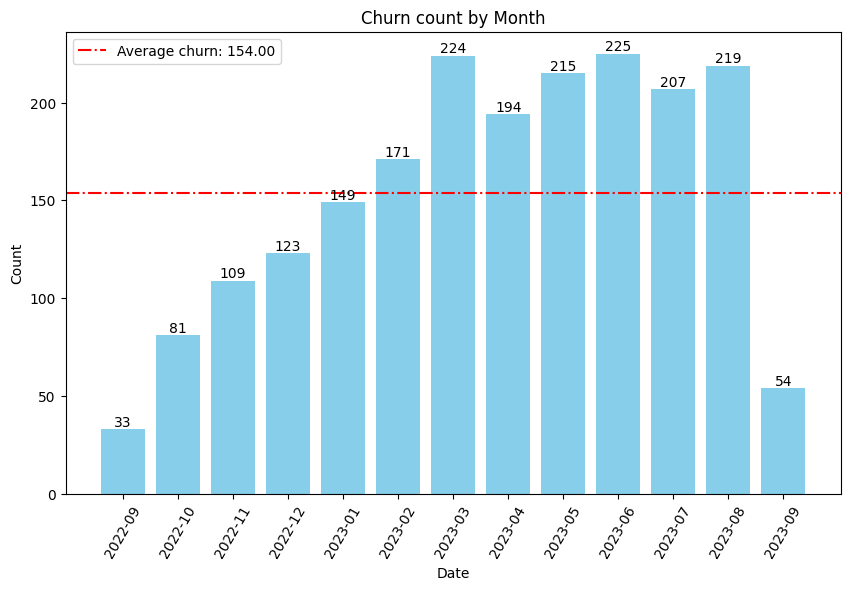

In [18]:
# Convert 'date columns' to datetime
subs_df['created_date'] = pd.to_datetime(subs_df['created_date'], errors='coerce')
subs_df['canceled_date'] = pd.to_datetime(subs_df['canceled_date'], errors='coerce')

# Extract month and year, then group by this new column
subs_df['created_month'] = subs_df['created_date'].dt.to_period('M')
subs_df['canceled_month'] = subs_df['canceled_date'].dt.to_period('M')

# Calculate the churn count for each month
monthly_churn = subs_df.groupby('canceled_month')['canceled_date'].count()

# Convert the result to a DataFrame
monthly_churn_df = monthly_churn.reset_index(name='churn_count')

# Plot the Graph
plt.figure(figsize=(10, 6))
bars = plt.bar(monthly_churn_df['canceled_month'].dt.strftime('%Y-%m'), monthly_churn_df['churn_count'], color='skyblue')
plt.title('Churn count by Month')
plt.xlabel('Date')
plt.ylabel('Count')

# Add horizontal line for the average value
average_churn = int(monthly_churn_df['churn_count'].mean())
plt.axhline(average_churn, color='red', linestyle='dashdot', label=f'Average churn: {average_churn:.2f}')
plt.legend()

# Add data labels on each bar
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, int(yval), ha='center', va='bottom')

plt.xticks(rotation=60)
plt.show()

# 2. Subscription Retention Analysis
- Average Subscription duration
- Categorize Subscription duration
- Average Subscription Duration by Payment Status

In [19]:
# Calculate subscription duration
subs_df['subscription_duration'] = (subs_df['canceled_date'] - subs_df['created_date']).dt.days

# Display the DataFrame with the new column
subs_df.head(3)

,customer_id,created_date,canceled_date,was_subscription_paid,created_month,canceled_month,subscription_duration
0,154536156,2022-09-01,NaT,1,2022-09,NaT,NaN
1,149713408,2022-09-01,2022-09-02,0,2022-09,2022-09,1.0
2,153756284,2022-09-01,2022-09-02,0,2022-09,2022-09,1.0


In [20]:
subs_df['subscription_duration'].describe()

count    2004.000000
mean       58.374251
std        56.906846
min         0.000000
25%        22.000000
50%        38.000000
75%        83.000000
max       348.000000
Name: subscription_duration, dtype: float64

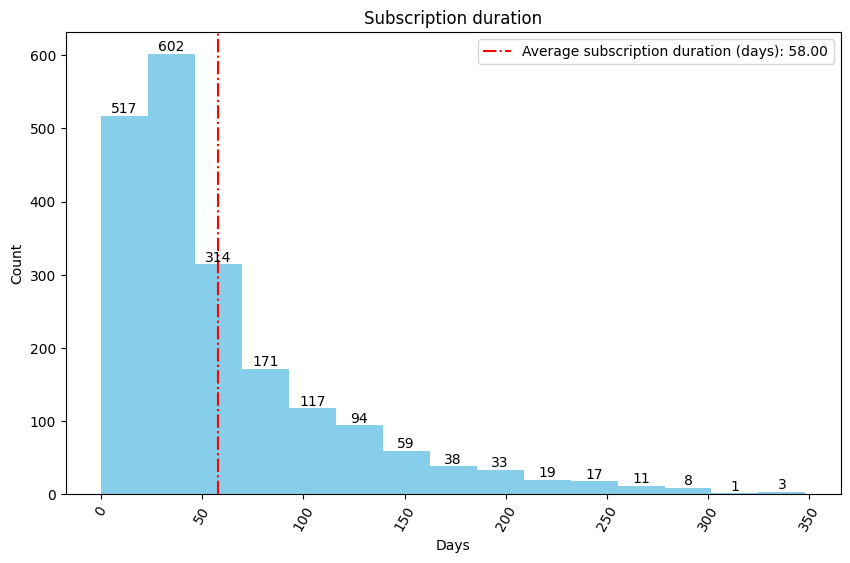

In [21]:
# Plot the Graph
plt.figure(figsize=(10, 6))
hist_values, bins, patches = plt.hist(subs_df['subscription_duration'], bins=15, color='skyblue')
plt.title('Subscription duration')
plt.xlabel('Days')
plt.ylabel('Count')

# Add horizontal line for the average value
average_subscription_duration = int(subs_df['subscription_duration'].mean())
plt.axvline(average_subscription_duration, color='red', linestyle='dashdot', label=f'Average subscription duration (days): {average_subscription_duration:.2f}')
plt.legend()

# Add data labels on each bar
for i in range(len(hist_values)):
    yval = hist_values[i]
    xval = (bins[i] + bins[i+1])/2
    plt.text(xval, yval, int(yval), ha='center', va='bottom')


plt.xticks(rotation=60)
plt.show()

Categorize subscription duration

In [22]:
# Define bins:
bins = [0, 7, 30, 60, 90, 120, 150, 180, 365, 730]

# Define labels for each bin
labels = ['0-7 days', '8-30 days', '31-60 days', '61-90 days', '91-120 days',
          '121-150 days', '151-180 days', '181-365 days', '1-2 years']

# Create the bins and categorize subscription duration
subs_df['duration_group'] = pd.cut(subs_df['subscription_duration'], bins=bins, labels=labels)
subs_df.head(3)

,customer_id,created_date,canceled_date,was_subscription_paid,created_month,canceled_month,subscription_duration,duration_group
0,154536156,2022-09-01,NaT,1,2022-09,NaT,NaN,NaN
1,149713408,2022-09-01,2022-09-02,0,2022-09,2022-09,1.0,0-7 days
2,153756284,2022-09-01,2022-09-02,0,2022-09,2022-09,1.0,0-7 days


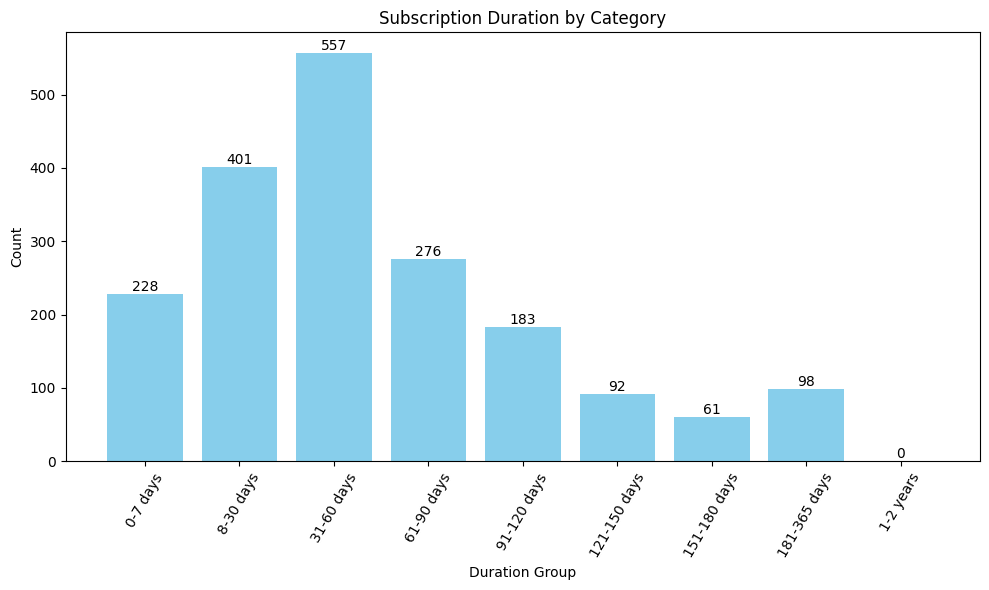

In [23]:
# Ensure 'duration_group' is binned according to these categories, and count the occurrences
duration_counts = subs_df['duration_group'].value_counts().reindex(labels, fill_value=0)

# Plot the Graph
plt.figure(figsize=(10, 6))
bars = plt.bar(labels, duration_counts.values, color='skyblue')
plt.title('Subscription Duration by Category')
plt.xlabel('Duration Group')
plt.ylabel('Count')

# Add data labels on each bar
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, yval, int(yval), ha='center', va='bottom')

# Rotate the x-axis labels for better readability
plt.xticks(rotation=60)

plt.tight_layout()
plt.show()


Analyze patterns in retention based on whether the subscription was paid.


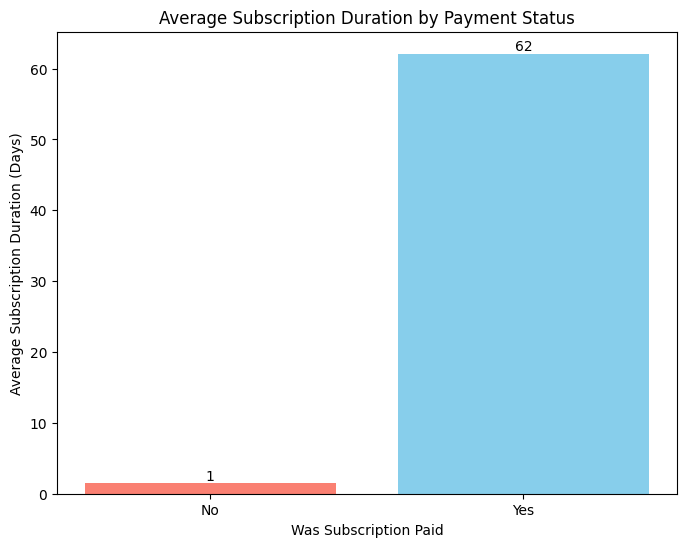

In [24]:
# Group by "was_subscription_paid" and calculate the average subscription duration for each group
retention_by_payment = subs_df.groupby('was_subscription_paid')['subscription_duration'].mean()

# Plot the Graph
plt.figure(figsize=(8, 6))
bars = plt.bar(retention_by_payment.index, retention_by_payment.values, color=['salmon', 'skyblue'])
plt.title('Average Subscription Duration by Payment Status')
plt.xlabel('Was Subscription Paid')
plt.ylabel('Average Subscription Duration (Days)')
plt.xticks([0, 1], ['No', 'Yes'])

# Add data labels on each bar
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, yval, int(yval), ha='center', va='bottom')

plt.show()

# 3. Revenue Analysis
- Monthly accounts created
- Monthly revenue

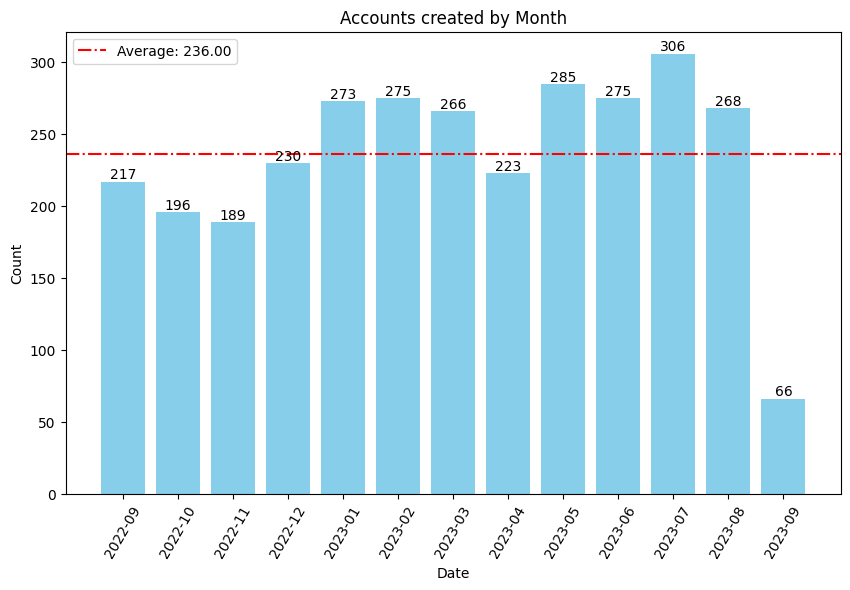

In [25]:
# Calculate the accounts created for each month
monthly_acc = subs_df.groupby('created_month')['created_date'].count()

# Convert the result to a DataFrame
monthly_acc_df = monthly_acc.reset_index(name='accounts_created')

# Plot the Graph
plt.figure(figsize=(10, 6))
bars = plt.bar(monthly_acc_df['created_month'].dt.strftime('%Y-%m'), monthly_acc_df['accounts_created'], color='skyblue')
plt.title('Accounts created by Month')
plt.xlabel('Date')
plt.ylabel('Count')

# Add horizontal line for the average value
monthly_average_accounts_created = int(monthly_acc_df['accounts_created'].mean())
plt.axhline(monthly_average_accounts_created, color='red', linestyle='dashdot', label=f'Average: {monthly_average_accounts_created:.2f}')
plt.legend()

# Add data labels on each bar
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, int(yval), ha='center', va='bottom')

plt.xticks(rotation=60)
plt.show()

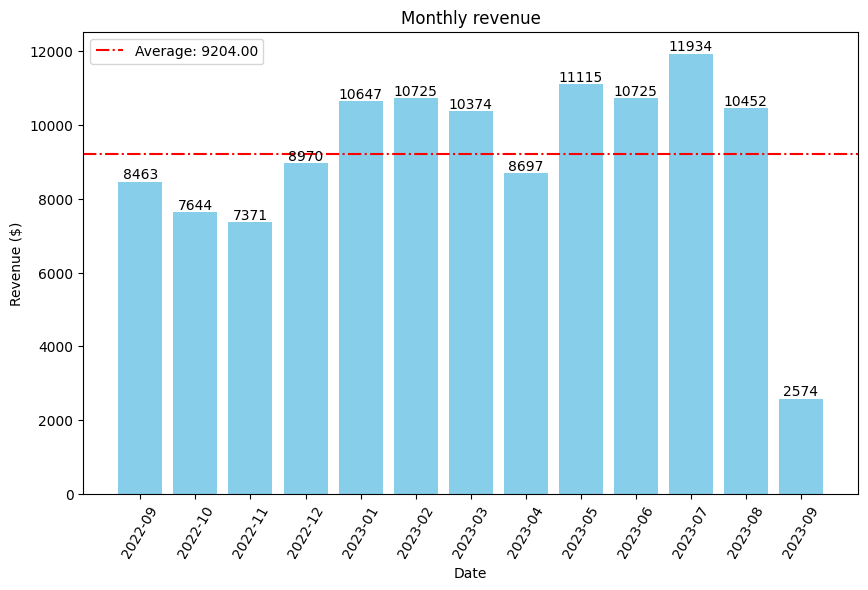

In [26]:
# Calculate the accounts created for each month
monthly_revenue = subs_df.groupby('created_month')['created_date'].count()

# Convert the result to a DataFrame
monthly_revenue_df = monthly_acc.reset_index(name='monthly_revenue')

# Plot the Graph
plt.figure(figsize=(10, 6))
bars = plt.bar(monthly_revenue_df['created_month'].dt.strftime('%Y-%m'), monthly_revenue_df['monthly_revenue']*subscription_cost, color='skyblue')
plt.title('Monthly revenue')
plt.xlabel('Date')
plt.ylabel('Revenue ($)')

# Add horizontal line for the average value
average_revenue = int(monthly_acc_df['accounts_created'].mean())
plt.axhline(average_revenue*subscription_cost, color='red', linestyle='dashdot', label=f'Average: {average_revenue*subscription_cost:.2f}')
plt.legend()

# Add data labels on each bar
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, int(yval), ha='center', va='bottom')

plt.xticks(rotation=60)
plt.show()

# 4. Customer Segmentation
- Classify customers into categories
    1. Active
    2. Short-term (1 to 3 months)
    3. Churner (within a month)
    4. Mid-term (3 months to 6 months)
    5. Resubscriber
    6. Free trial
    7. Long-term (6 months to 1 year)
    8. Irregular Subscriber

- Get Count and Countribution
- Get Active Subscribers

In [27]:
# Create a new 'category' column in subs_df and initialize with empty strings
subs_df['customer_category'] = ''

# Count the number of subscriptions for each customer
customer_count = subs_df['customer_id'].value_counts()

# Classify customers based on subscription duration and payment status, and assign directly to subs_df
for customer_id in subs_df['customer_id'].unique():
    customer_data = subs_df[subs_df['customer_id'] == customer_id]
    duration = customer_data['subscription_duration'].max()
    paid = customer_data['was_subscription_paid'].any()
    count = customer_count[customer_id]

    if count == 2:
        category = 'Resubscriber'
    elif count == 3:
        category = 'Irregular Subscriber'
    elif not paid:
        category = 'Free trial'
    elif pd.isnull(duration) and paid:
        category = 'Active'
    elif duration <= 30:
        category = 'Churner (within a month)'
    elif 30 < duration <= 90:
        category = 'Short-term (1 to 3 months)'
    elif 90 < duration <= 180:
        category = 'Mid-term (3 months to 6 months)'
    elif 180 < duration <= 365:
        category = 'Long-term (6 months to 1 year)'
    elif duration > 365:
        category = 'Loyal (> a year)'
    else:
        category = 'Unknown'

    # Assign the category to all rows for the current customer_id
    subs_df.loc[subs_df['customer_id'] == customer_id, 'customer_category'] = category

# Display the updated subs_df with the category column
subs_df.head()


,customer_id,created_date,canceled_date,was_subscription_paid,created_month,canceled_month,subscription_duration,duration_group,customer_category
0,154536156,2022-09-01,NaT,1,2022-09,NaT,NaN,NaN,Active
1,149713408,2022-09-01,2022-09-02,0,2022-09,2022-09,1.0,0-7 days,Free trial
2,153756284,2022-09-01,2022-09-02,0,2022-09,2022-09,1.0,0-7 days,Free trial
3,121253113,2022-09-01,2022-09-23,1,2022-09,2022-09,22.0,8-30 days,Resubscriber
4,154467210,2022-09-01,2023-06-29,1,2022-09,2023-06,301.0,181-365 days,Long-term (6 months to 1 year)


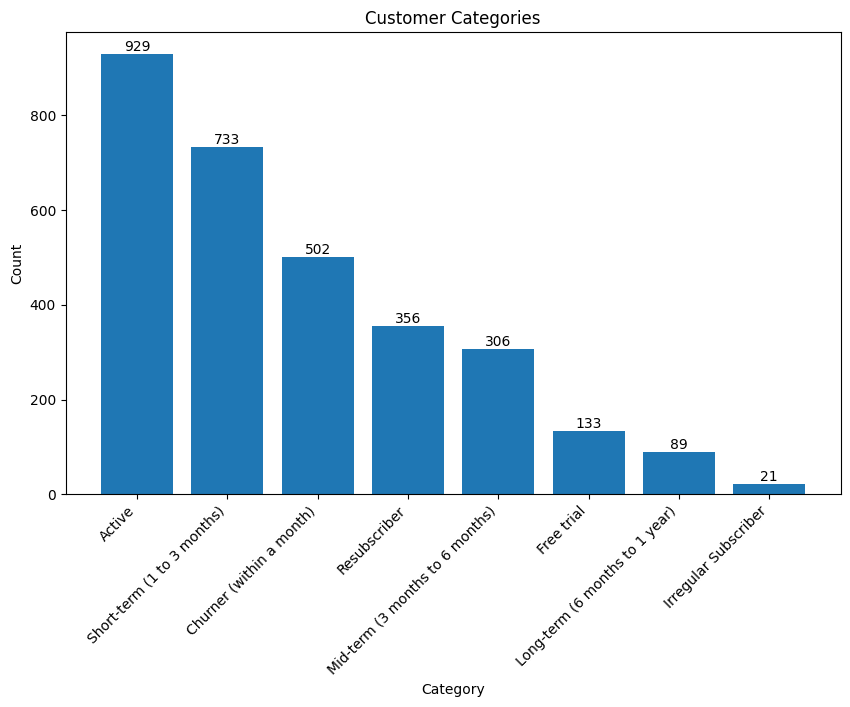

In [28]:
# Count the occurrences of each category in the 'customer_category' column
category_counts = subs_df['customer_category'].value_counts()

# Plot the graph
plt.figure(figsize=(10, 6))
bars = plt.bar(category_counts.index, category_counts.values)
plt.title('Customer Categories')
plt.xlabel('Category')
plt.ylabel('Count')

# Add data labels on each bar
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, int(yval), ha='center', va='bottom')

plt.xticks(rotation=45, ha='right')
plt.show()

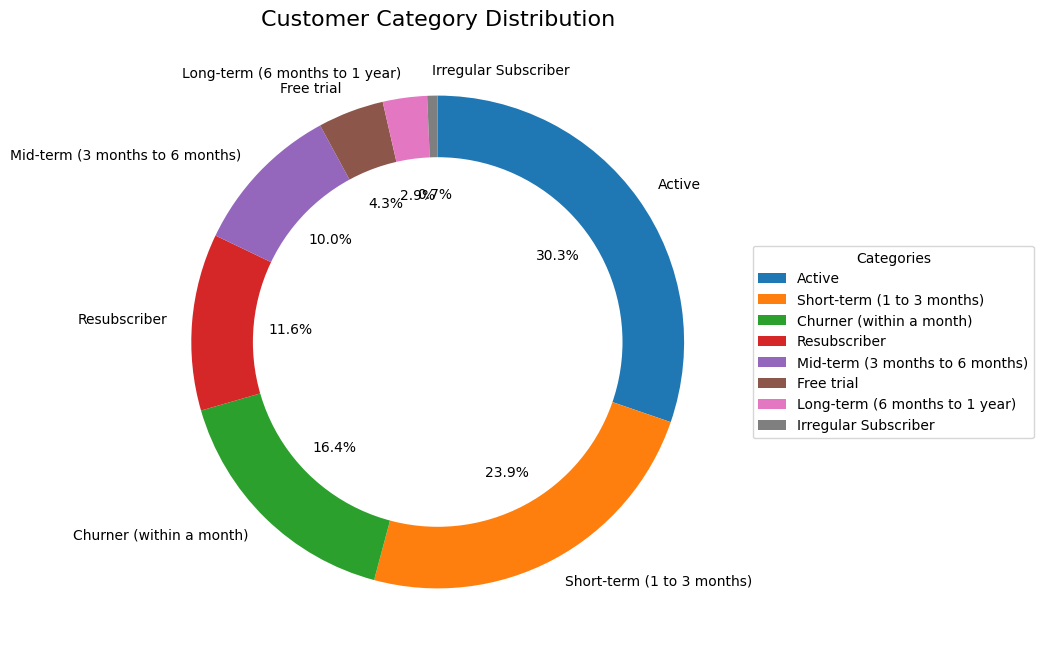

In [29]:
# Plot a donut chart
plt.figure(figsize=(8, 8))

# Create a pie chart
wedges, texts, autotexts = plt.pie(
    category_counts.values,
    labels=category_counts.index,
    autopct='%1.1f%%',
    startangle=90,
    counterclock=False,
    wedgeprops=dict(width=0.75)  # This creates the hole for the donut effect
)

# To avoid overlapping of last label
for i, text in enumerate(texts):
    if i >= len(texts)-1:
        text.set_horizontalalignment('left')

# Draw a circle at the center to make it look like a donut
centre_circle = plt.Circle((0, 0), 0.75, fc='white')
fig = plt.gcf()
fig.gca().add_artist(centre_circle)

# Set title and equal axis to make it circular
plt.title('Customer Category Distribution', fontsize=16)
plt.gca().set_aspect('equal')

# Add a legend outside the donut chart
plt.legend(wedges, category_counts.index, title='Categories', loc='center left', bbox_to_anchor=(1, 0, 0.5, 1))

plt.show()

## Get Active Subscribers

In [30]:
active_subcribers = subs_df[subs_df['customer_category'] == 'Active']
active_subcribers.head(3)

,customer_id,created_date,canceled_date,was_subscription_paid,created_month,canceled_month,subscription_duration,duration_group,customer_category
0,154536156,2022-09-01,NaT,1,2022-09,NaT,NaN,NaN,Active
12,152925600,2022-09-02,NaT,1,2022-09,NaT,NaN,NaN,Active
18,154131290,2022-09-03,NaT,1,2022-09,NaT,NaN,NaN,Active


# 5. Subscription Cost Impact
>No impact by different pricing because we have only one price for all customers

# 6. Subscription Lifespan Prediction
- Predict whether a customer will cancel based on their initial subscription behavior.


## a. Data Preparation

In [31]:
model_df = subs_df.copy(deep=True)
model_df.head(3)

,customer_id,created_date,canceled_date,was_subscription_paid,created_month,canceled_month,subscription_duration,duration_group,customer_category
0,154536156,2022-09-01,NaT,1,2022-09,NaT,NaN,NaN,Active
1,149713408,2022-09-01,2022-09-02,0,2022-09,2022-09,1.0,0-7 days,Free trial
2,153756284,2022-09-01,2022-09-02,0,2022-09,2022-09,1.0,0-7 days,Free trial


In [32]:
# Replace NA values with '2024-12-31' in 'canceled_date' column
model_df['canceled_date'] = model_df['canceled_date'].fillna(pd.to_datetime('2024-12-31'))

# Recalculate subscription duration
model_df['subscription_duration'] = (model_df['canceled_date'] - model_df['created_date']).dt.days

model_df.head(3)

,customer_id,created_date,canceled_date,was_subscription_paid,created_month,canceled_month,subscription_duration,duration_group,customer_category
0,154536156,2022-09-01,2024-12-31,1,2022-09,NaT,852,NaN,Active
1,149713408,2022-09-01,2022-09-02,0,2022-09,2022-09,1,0-7 days,Free trial
2,153756284,2022-09-01,2022-09-02,0,2022-09,2022-09,1,0-7 days,Free trial


In [33]:
# If "canceled_date" is not null, it means the subscription was canceled.

model_df['canceled'] = model_df['canceled_month'].notna().astype(int)
model_df.head(3)

,customer_id,created_date,canceled_date,was_subscription_paid,created_month,canceled_month,subscription_duration,duration_group,customer_category,canceled
0,154536156,2022-09-01,2024-12-31,1,2022-09,NaT,852,NaN,Active,0
1,149713408,2022-09-01,2022-09-02,0,2022-09,2022-09,1,0-7 days,Free trial,1
2,153756284,2022-09-01,2022-09-02,0,2022-09,2022-09,1,0-7 days,Free trial,1


In [34]:
# Convert categorical features into numerical format using one-hot encoding or label encoding.

model_df = pd.get_dummies(model_df, columns=['duration_group', 'customer_category'], drop_first=True) # drop_first = True means delete original column after encoding
model_df.head(3)

,customer_id,created_date,canceled_date,was_subscription_paid,created_month,canceled_month,subscription_duration,canceled,duration_group_8-30 days,duration_group_31-60 days,...,duration_group_151-180 days,duration_group_181-365 days,duration_group_1-2 years,customer_category_Churner (within a month),customer_category_Free trial,customer_category_Irregular Subscriber,customer_category_Long-term (6 months to 1 year),customer_category_Mid-term (3 months to 6 months),customer_category_Resubscriber,customer_category_Short-term (1 to 3 months)
0,154536156,2022-09-01,2024-12-31,1,2022-09,NaT,852,0,False,False,...,False,False,False,False,False,False,False,False,False,False
1,149713408,2022-09-01,2022-09-02,0,2022-09,2022-09,1,1,False,False,...,False,False,False,False,True,False,False,False,False,False
2,153756284,2022-09-01,2022-09-02,0,2022-09,2022-09,1,1,False,False,...,False,False,False,False,True,False,False,False,False,False


In [35]:
# Convert created_month column to int of month_num jan as 1 till dec 12

# Convert 'created_month' to datetime objects if it's not already
model_df['created_date'] = pd.to_datetime(model_df['created_date'], errors='coerce')
model_df['canceled_date'] = pd.to_datetime(model_df['canceled_date'], errors='coerce')

# Convert 'created_month' to integer representation of month number (1-12)
model_df['created_month_num'] = model_df['created_date'].dt.month
model_df['canceled_month_num'] = model_df['canceled_date'].dt.month

# Remove the original 'created_month' column if you don't need it anymore
model_df = model_df.drop('created_date', axis=1)
model_df = model_df.drop('canceled_date', axis=1)

# Display the updated DataFrame
model_df.head(3)

,customer_id,was_subscription_paid,created_month,canceled_month,subscription_duration,canceled,duration_group_8-30 days,duration_group_31-60 days,duration_group_61-90 days,duration_group_91-120 days,...,duration_group_1-2 years,customer_category_Churner (within a month),customer_category_Free trial,customer_category_Irregular Subscriber,customer_category_Long-term (6 months to 1 year),customer_category_Mid-term (3 months to 6 months),customer_category_Resubscriber,customer_category_Short-term (1 to 3 months),created_month_num,canceled_month_num
0,154536156,1,2022-09,NaT,852,0,False,False,False,False,...,False,False,False,False,False,False,False,False,9,12
1,149713408,0,2022-09,2022-09,1,1,False,False,False,False,...,False,False,True,False,False,False,False,False,9,9
2,153756284,0,2022-09,2022-09,1,1,False,False,False,False,...,False,False,True,False,False,False,False,False,9,9


In [36]:
features = ['was_subscription_paid', 'created_month_num', 'canceled_month_num', 'subscription_duration', 'duration_group_8-30 days',
            'duration_group_31-60 days', 'duration_group_61-90 days', 'duration_group_91-120 days', 'duration_group_121-150 days',
            'duration_group_151-180 days', 'duration_group_181-365 days', 'duration_group_1-2 years',
            'customer_category_Free trial', 'customer_category_Irregular Subscriber', 'customer_category_Long-term (6 months to 1 year)',
            'customer_category_Mid-term (3 months to 6 months)', 'customer_category_Resubscriber', 'customer_category_Short-term (1 to 3 months)']

target = 'canceled'

X = model_df[features]
y = model_df[target]


## b. Train-Test Split

In [37]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
X_train.head(3)

,was_subscription_paid,created_month_num,canceled_month_num,subscription_duration,duration_group_8-30 days,duration_group_31-60 days,duration_group_61-90 days,duration_group_91-120 days,duration_group_121-150 days,duration_group_151-180 days,duration_group_181-365 days,duration_group_1-2 years,customer_category_Free trial,customer_category_Irregular Subscriber,customer_category_Long-term (6 months to 1 year),customer_category_Mid-term (3 months to 6 months),customer_category_Resubscriber,customer_category_Short-term (1 to 3 months)
2095,1,5,6,23,True,False,False,False,False,False,False,False,False,False,False,False,False,False
229,1,10,10,24,True,False,False,False,False,False,False,False,False,False,False,False,False,False
2567,1,7,8,38,False,True,False,False,False,False,False,False,False,False,False,False,True,False


## c. Model Building

In [38]:
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier(random_state=42)
model.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

## d. Model Evaluation

- **Accuracy:** Good for balanced datasets, measures overall performance.

In [39]:
from sklearn.metrics import accuracy_score

y_pred = model.predict(X_test)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)

# Print the accuracy
print(f'Accuracy: {accuracy:.4f}')

Accuracy: 1.0000


- **ROC AUC:** Measures the model's ability to rank positive cases higher than negative ones, useful for understanding the model’s ranking ability across different thresholds.

In [40]:
from sklearn.metrics import classification_report, roc_auc_score

# Predictions
y_pred = model.predict(X_test)

# Evaluation metrics
print(classification_report(y_test, y_pred))

# Check the unique values in y_test
print('Unique values in y_test:', np.unique(y_test))

if len(np.unique(y_test)) > 1:
    print('ROC AUC Score:', roc_auc_score(y_test, y_pred))
else:
    print('ROC AUC Score cannot be calculated because only one class is present in y_test.')

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       317
           1       1.00      1.00      1.00       604

    accuracy                           1.00       921
   macro avg       1.00      1.00      1.00       921
weighted avg       1.00      1.00      1.00       921

Unique values in y_test: [0 1]
ROC AUC Score: 1.0


## e. Feature Importance
Determine which features are most important for predicting cancellations.

In [41]:
importances = model.feature_importances_
features = X.columns
feature_importance_df = pd.DataFrame({'Feature': features, 'Importance': importances})
print(feature_importance_df.sort_values(by='Importance', ascending=False))


                                              Feature  Importance
3                               subscription_duration    0.459911
2                                  canceled_month_num    0.381109
17       customer_category_Short-term (1 to 3 months)    0.045846
5                           duration_group_31-60 days    0.032778
4                            duration_group_8-30 days    0.029042
15  customer_category_Mid-term (3 months to 6 months)    0.014460
1                                   created_month_num    0.009301
6                           duration_group_61-90 days    0.008879
7                          duration_group_91-120 days    0.006369
12                       customer_category_Free trial    0.003494
8                         duration_group_121-150 days    0.002491
0                               was_subscription_paid    0.001991
14   customer_category_Long-term (6 months to 1 year)    0.001615
16                     customer_category_Resubscriber    0.001219
10        

## The provided output shows the feature importance for predicting cancellations. Based on the `Importance` values, we can infer the following:

**Most important features:**

- **subscription_duration:** This feature has the highest importance, indicating that it's the most crucial factor in predicting cancellations. Longer subscription durations might be associated with lower cancellation rates.
- **canceled_month_num:** This feature also has a significant impact on cancellation prediction. It might reveal patterns related to seasonal cancellations or specific time periods when customers are more likely to cancel.

**Less important features:**

- **customer_category_Irregular Subscriber:** This category has the lowest importance, suggesting that it has little or no influence on cancellation prediction.

# Test likelihood of churn of a new customer

In [42]:
# Ensure that the new data is processed (e.g., categorical features encoded) similarly to the training data

# Replace the values with your specific customer data
new_customer_data = pd.DataFrame({
    'was_subscription_paid': [1],
    'created_month_num': [2],
    'canceled_month_num': [9],
    'subscription_duration': [200],
    'duration_group_8-30 days': [0],
    'duration_group_31-60 days': [0],
    'duration_group_61-90 days': [0],
    'duration_group_91-120 days': [0],
    'duration_group_121-150 days': [0],
    'duration_group_151-180 days': [0],
    'duration_group_181-365 days': [1],
    'duration_group_1-2 years': [0],
    'customer_category_Free trial': [0],
    'customer_category_Irregular Subscriber': [0],
    'customer_category_Long-term (6 months to 1 year)': [1],
    'customer_category_Mid-term (3 months to 6 months)': [0],
    'customer_category_Resubscriber': [0],
    'customer_category_Short-term (1 to 3 months)': [0]
})

# Predict probability of churn (1) or non-churn (0)
churn_prob = model.predict_proba(new_customer_data)

# churn_prob gives probabilities for both classes: [probability of not churning, probability of churning]
churn_likelihood = churn_prob[0][1]  # Get probability of churn

print(f'Likelihood of churn: {churn_likelihood:.4f}')

Likelihood of churn: 1.0000
